In [1]:
import sys
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Adiciona o caminho para a pasta 'src' ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'src')))

from data_analysis import *
from data_preprocessing import *
from visualization import *

In [2]:
# Caminho para o banco de dados SQLite
db_path = r"C:\GitHub\Projeto-Power-BI-Data-Analysis\data\processed\stg\stg_data.db"

# Conecta ao banco de dados
conn = sqlite3.connect(db_path)
cursor = conn.cursor()


In [3]:
df_olist_customers = pd.read_sql_query(f"SELECT * FROM  stg_olist_customers", conn)
# Fechar a conexão
conn.close()
df_olist_customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
analisar_categorias(df_olist_customers)


,Categorias Únicas
customer_id,99441
customer_unique_id,96096
customer_city,4119
customer_state,27


In [6]:
contar_valores_nulos(df_olist_customers)

,Total Nulos,Percentual (%)
customer_id,0,0.0
customer_unique_id,0,0.0
customer_zip_code_prefix,0,0.0
customer_city,0,0.0
customer_state,0,0.0


In [7]:
verificar_tipos_dados(df_olist_customers)

,Tipo de Dado
customer_id,object
customer_unique_id,object
customer_zip_code_prefix,int64
customer_city,object
customer_state,object


In [8]:
encontrar_colunas_constantes(df_olist_customers)

[]

In [9]:
identificar_outliers(df_olist_customers, "customer_zip_code_prefix", metodo="desvio_padrao", fator=2.7)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [10]:
print(df_olist_customers.select_dtypes(include=["number"]).head())


   customer_zip_code_prefix
0                     14409
1                      9790
2                      1151
3                      8775
4                     13056


*Análise da Matriz de Correlação*

A matriz mostra a correlação entre as variáveis do dataset. Os valores variam de -1 a 1, onde:

- 1.00 indica correlação perfeita positiva. 
- 0.00 indica ausência de correlação. 
- -1.00 indica correlação perfeita negativa. 

customer_zip_code_prefix tem uma influência moderada sobre customer_city e customer_state, o que faz sentido geograficamente.
customer_id e customer_unique_id não possuem relevância para a análise de correlação. Se o objetivo for prever ou entender padrões, essas colunas podem ser descartadas.
A correlação entre customer_state e customer_city é fraca (~0.26), indicando que há variação significativa dentro dos estados.

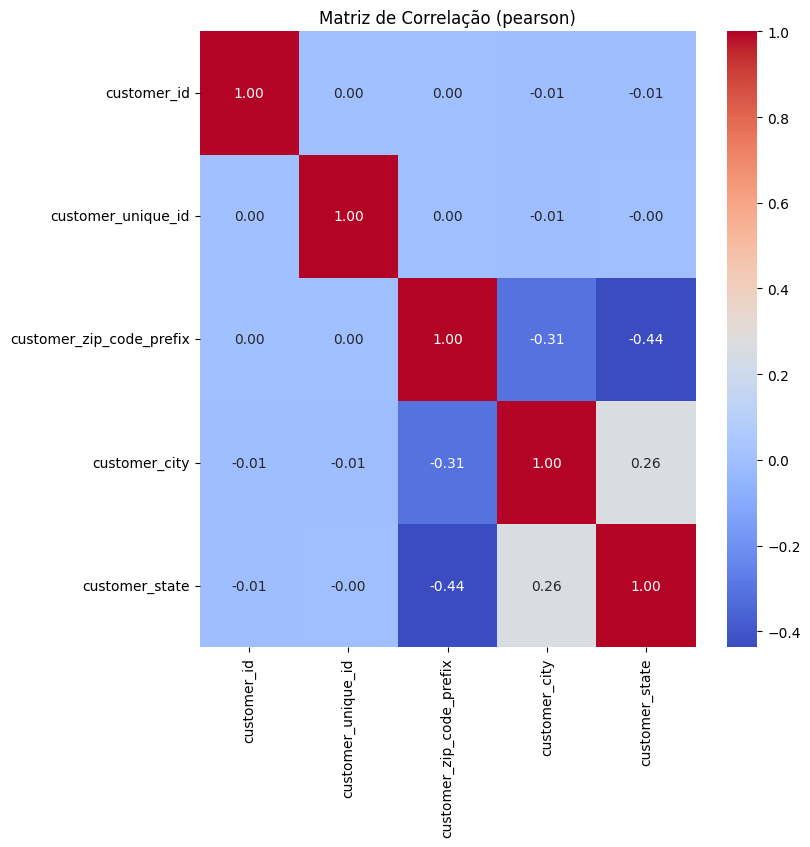

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
customer_id,1.000000,0.002560,0.002042,-0.005715,-0.005860
customer_unique_id,0.002560,1.000000,0.000202,-0.006406,-0.002416
customer_zip_code_prefix,0.002042,0.000202,1.000000,-0.308916,-0.437663
customer_city,-0.005715,-0.006406,-0.308916,1.000000,0.262024
customer_state,-0.005860,-0.002416,-0.437663,0.262024,1.000000


In [11]:
plot_matriz_correlacao_Encoding(df_olist_customers, method="pearson")


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_olist_customers["customer_city_encoded"] = le.fit_transform(df_olist_customers["customer_city"])


In [13]:
import pandas as pd
import unidecode
from collections import defaultdict
from fuzzywuzzy import fuzz

def detectar_variacoes(df, coluna, limite_similaridade=85):
    """
    Detecta variações de escrita em uma coluna de um DataFrame.

    Parâmetros:
    - df: DataFrame do pandas.
    - coluna: Nome da coluna a ser analisada.
    - limite_similaridade: Percentual de similaridade mínimo para agrupar palavras (padrão: 85%).

    Retorna:
    - Dicionário com os grupos de variações.
    """

    # Normaliza os nomes (minúsculas, remove acentos, espaços extras)
    df["__normalizado__"] = df[coluna].astype(str).str.lower().apply(lambda x: unidecode.unidecode(x.strip()))

    # Lista única de valores normalizados
    valores_unicos = df["__normalizado__"].unique()

    # Agrupar nomes semelhantes
    grupos = defaultdict(list)

    for nome1 in valores_unicos:
        encontrado = False
        for chave in grupos:
            if fuzz.ratio(nome1, chave) >= limite_similaridade:
                grupos[chave].append(nome1)
                encontrado = True
                break
        if not encontrado:
            grupos[nome1].append(nome1)

    # Remover coluna temporária
    df.drop(columns=["__normalizado__"], inplace=True)

    return dict(grupos)


c:\GitHub\Projeto-Power-BI-Data-Analysis\.venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [14]:


variacoes = detectar_variacoes(df_olist_customers, "customer_city")

for chave, grupo in variacoes.items():
    print(f"Grupo: {chave} -> Variações: {grupo}")


Grupo: franca -> Variações: ['franca']
Grupo: sao bernardo do campo -> Variações: ['sao bernardo do campo']
Grupo: sao paulo -> Variações: ['sao paulo']
Grupo: mogi das cruzes -> Variações: ['mogi das cruzes']
Grupo: campinas -> Variações: ['campinas']
Grupo: jaragua do sul -> Variações: ['jaragua do sul']
Grupo: timoteo -> Variações: ['timoteo']
Grupo: curitiba -> Variações: ['curitiba', 'muritiba']
Grupo: belo horizonte -> Variações: ['belo horizonte', 'belo oriente', 'alto horizonte']
Grupo: montes claros -> Variações: ['montes claros']
Grupo: rio de janeiro -> Variações: ['rio de janeiro']
Grupo: lencois paulista -> Variações: ['lencois paulista']
Grupo: caxias do sul -> Variações: ['caxias do sul', 'campinas do sul']
Grupo: piracicaba -> Variações: ['piracicaba']
Grupo: guarulhos -> Variações: ['guarulhos']
Grupo: pacaja -> Variações: ['pacaja']
Grupo: florianopolis -> Variações: ['florianopolis']
Grupo: aparecida de goiania -> Variações: ['aparecida de goiania']
Grupo: santo andr

In [15]:
df_olist_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_city_encoded
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1382
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,3428
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,3597
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,2341
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,707
...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,3597
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,3775
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,1374
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,772


In [26]:
import unidecode

def normalizar_texto(texto):
    """
    Remove acentos e transforma o texto em minúsculas.
    
    Parâmetros:
    - texto (str): String a ser normalizada.

    Retorna:
    - str: Texto sem acentos e em minúsculas.
    """
    return unidecode.unidecode(texto).lower()


In [27]:
df_olist_customers["customer_city_normalizado"] = df_olist_customers["customer_city"].apply(normalizar_texto)


In [ ]:
df_cidades = pd.DataFrame(sorted(df_olist_customers["customer_city"].unique()), columns=["customer_city"])




In [36]:
df_sao_paulo = df_olist_customers[
    df_olist_customers["customer_city"].apply(lambda x: "sao pau" in normalizar_texto(x))
]
df_sao_paulo["customer_city"].unique()

array(['sao paulo', 'sao paulo do potengi', 'morro de sao paulo',
       'sao paulo das missoes'], dtype=object)

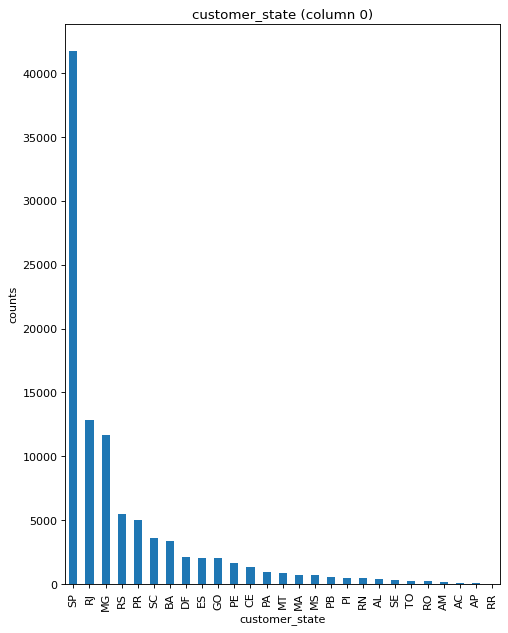

In [12]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]  # Para exibição, escolha colunas com 2 a 49 valores únicos
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Correção: divisão inteira
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()


plotPerColumnDistribution(df_olist_customers, 8, 2)

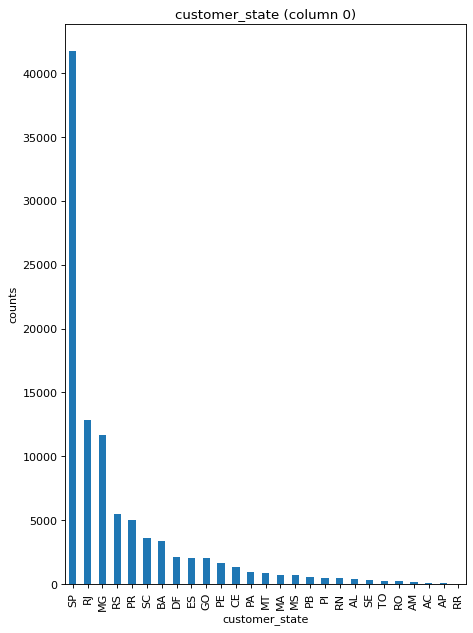

In [15]:
plotPerColumnDistribution(df_olist_customers, 11, 1)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plotar_distribuicao_coluna(df, coluna_x, quantidade_categorias, ordenar_por='contagem'):
    """
    Plota a distribuição de uma coluna específica do DataFrame.
    Agrupa categorias menos frequentes em "Outros" se o número de categorias for maior que o limite especificado.
    Ordena as categorias conforme especificado em ordenar_por.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna_x (str): O nome da coluna a ser plotada no eixo x.
        quantidade_categorias (int): Quantidade maxima de categorias a serem mostradas.
        ordenar_por (str): Critério de ordenação ('contagem' ou 'indice').
    """
    if coluna_x not in df.columns:
        print(f"Coluna '{coluna_x}' não encontrada no DataFrame.")
        return

    qtd_categoria_coluna = df[coluna_x]

    # Verifica se a coluna é numérica para plotar histograma
    if pd.api.types.is_numeric_dtype(qtd_categoria_coluna):
        plt.figure(figsize=(10, 6))
        qtd_categoria_coluna.hist()
        plt.xlabel(coluna_x)
        plt.ylabel('Contagem')
        plt.title(f'Distribuição de {coluna_x}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        return

    contagem_valores = qtd_categoria_coluna.value_counts()
    # Caso a quantidade de categorias seja menor que o limite, ajusta o limite.
    if len(contagem_valores) < quantidade_categorias:
        quantidade_categorias = len(contagem_valores)

    # Agrupa categorias menos frequentes em "Outros" se o número de categorias for maior que o limite.
    if len(contagem_valores) > quantidade_categorias:
        top_n = contagem_valores.nlargest(quantidade_categorias)
        contagem_outros = contagem_valores[quantidade_categorias:].sum()
        top_n['Outros'] = contagem_outros
        contagem_valores = top_n

    # Ordena as categorias conforme especificado.
    if ordenar_por == 'contagem':
        contagem_valores = contagem_valores.sort_values(ascending=False)
    elif ordenar_por == 'indice':
        contagem_valores = contagem_valores.sort_index()

    plt.figure(figsize=(10, 6))
    contagem_valores.plot.bar()
    plt.xlabel(coluna_x)
    plt.ylabel('Contagem')
    plt.title(f'Contagem de {coluna_x}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plotar_distribuicoes_multiplas_colunas(df, colunas_x, numero_colunas_subplots=2, ordenar_por='contagem'):
    """
    Plota a distribuição de múltiplas colunas do DataFrame em subplots.
    Agrupa categorias menos frequentes em "Outros" se o número de categorias for maior que 10.
    Ordena as categorias conforme especificado em ordenar_por.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        colunas_x (list): Uma lista de nomes de colunas a serem plotadas no eixo x.
        numero_colunas_subplots (int): O número de colunas nos subplots.
        ordenar_por (str): Critério de ordenação ('contagem' ou 'indice').
    """
    numero_linhas_subplots = (len(colunas_x) + numero_colunas_subplots - 1) // numero_colunas_subplots
    plt.figure(figsize=(12, 6 * numero_linhas_subplots))

    for indice, coluna_x in enumerate(colunas_x):
        plt.subplot(numero_linhas_subplots, numero_colunas_subplots, indice + 1)

        if coluna_x not in df.columns:
            print(f"Coluna '{coluna_x}' não encontrada no DataFrame.")
            continue

        dados_coluna = df[coluna_x]

        if pd.api.types.is_numeric_dtype(dados_coluna):
            dados_coluna.hist()
            plt.xlabel(coluna_x)
            plt.ylabel('Contagem')
            plt.title(f'Distribuição de {coluna_x}')
            plt.xticks(rotation=45)
        else:
            contagem_valores = dados_coluna.value_counts()

            if len(contagem_valores) > 10:
                top_10 = contagem_valores.nlargest(10)
                contagem_outros = contagem_valores[10:].sum()
                top_10['Outros'] = contagem_outros
                contagem_valores = top_10

            if ordenar_por == 'contagem':
                contagem_valores = contagem_valores.sort_values(ascending=False)
            elif ordenar_por == 'indice':
                contagem_valores = contagem_valores.sort_index()

            contagem_valores.plot.bar()
            plt.xlabel(coluna_x)
            plt.ylabel('Contagem')
            plt.title(f'Contagem de {coluna_x}')
            plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

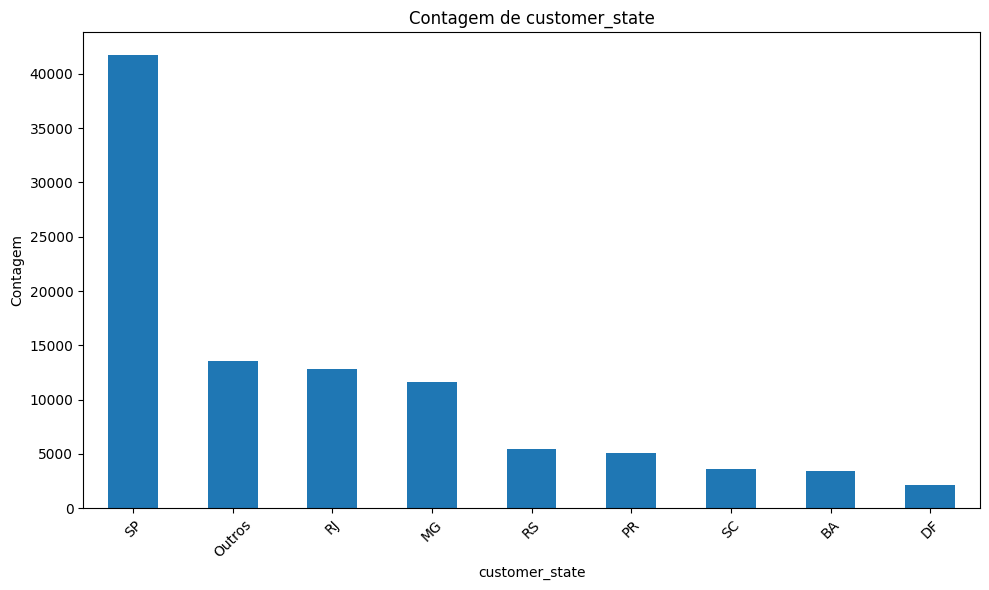

In [28]:

plotar_distribuicao_coluna(df_olist_customers, 'customer_state', quantidade_categorias=8)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plotar_distribuicoes_multiplas_colunas(df, colunas_x, quantidade_categorias=10, numero_colunas_subplots=2, ordenar_por='contagem'):
    """
    Plota a distribuição de múltiplas colunas do DataFrame em subplots.
    Agrupa categorias menos frequentes em "Outros" se o número de categorias for maior que `quantidade_categorias`.
    Ordena as categorias conforme especificado em `ordenar_por`.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        colunas_x (list): Lista de colunas a serem plotadas.
        quantidade_categorias (int): Número máximo de categorias antes de agrupar em "Outros".
        numero_colunas_subplots (int): Número de colunas nos subplots.
        ordenar_por (str): Critério de ordenação ('contagem' ou 'indice').
    """
    numero_linhas_subplots = (len(colunas_x) + numero_colunas_subplots - 1) // numero_colunas_subplots
    plt.figure(figsize=(12, 6 * numero_linhas_subplots))

    for indice, coluna_x in enumerate(colunas_x):
        plt.subplot(numero_linhas_subplots, numero_colunas_subplots, indice + 1)

        if coluna_x not in df.columns:
            print(f"Coluna '{coluna_x}' não encontrada no DataFrame.")
            continue

        dados_coluna = df[coluna_x]

        # Se for numérica, plota histograma
        if pd.api.types.is_numeric_dtype(dados_coluna):
            dados_coluna.hist()
            plt.xlabel(coluna_x)
            plt.ylabel('Contagem')
            plt.title(f'Distribuição de {coluna_x}')
            plt.xticks(rotation=45)

        else:
            contagem_valores = dados_coluna.value_counts()
            agregou_outros = False  # Flag para saber se "Outros" foi adicionado

            # Se houver mais categorias do que o limite, agrupa as menores em "Outros"
            if len(contagem_valores) > quantidade_categorias:
                top_n = contagem_valores.nlargest(quantidade_categorias)
                contagem_outros = contagem_valores[quantidade_categorias:].sum()
                top_n['Outros'] = contagem_outros
                contagem_valores = top_n
                agregou_outros = True

            # Ordena conforme o critério escolhido
            if ordenar_por == 'contagem':
                contagem_valores = contagem_valores.sort_values(ascending=False)
            elif ordenar_por == 'indice':
                contagem_valores = contagem_valores.sort_index()

            # Definir cores: "Outros" será laranja, o resto azul
            cores = ['orange' if categoria == 'Outros' else 'royalblue' for categoria in contagem_valores.index]

            # Plotando gráfico de barras
            contagem_valores.plot.bar(color=cores)
            plt.xlabel(coluna_x)
            plt.ylabel('Contagem')
            plt.title(f'Contagem de {coluna_x}')

            # Adicionando legenda explicativa
            if agregou_outros:
                plt.text(
                    0.5, -0.2, 
                    #"A categoria 'Outros' agrupa valores menos frequentes.", 
                    ha='center', va='center', fontsize=10, color='orange',
                    transform=plt.gca().transAxes
                )

                # Adiciona uma legenda visual na lateral
                plt.legend(["Outros (agregados)"], loc='upper right', fontsize=10, frameon=False)

            plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


TypeError: text() missing 1 required positional argument: 's'

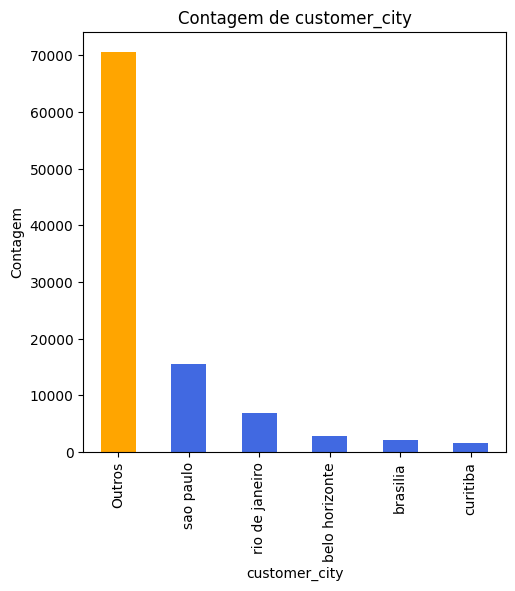

In [40]:
plotar_distribuicoes_multiplas_colunas(
    df_olist_customers, ['customer_city', 'customer_state', 'customer_zip_code_prefix','customer_state'],
      numero_colunas_subplots=2, quantidade_categorias=5)

In [30]:
df_olist_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_city_encoded
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1382
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,3428
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,3597
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,2341
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,707
...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,3597
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,3775
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,1374
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,772
